# The Power Spectrum

In this notebook, I will be characterizing and analyzing 2s of scalp EEG data sampled at 1000 Hz by their power spectrum using Fourier transforms, power spectral density, and spectrograms.

### Necessary Libraries

In [103]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from matplotlib import *
rcParams['figure.figsize'] = [12, 4]
from numpy.fft import fft, rfft
from scipy.signal import spectrogram

### The Data

The EEG data for which this case study is performed is from an unconscious male patient who was admitted to Massachussetts General Hospital (MGH). As part of his clinical workup, a scalp EEG sampled at 1000 Hz was taken. Although there were 21 electrodes placed on the scalp, we will only be inspecting a two second period of one electrode's results. 

## Visualizing the Data

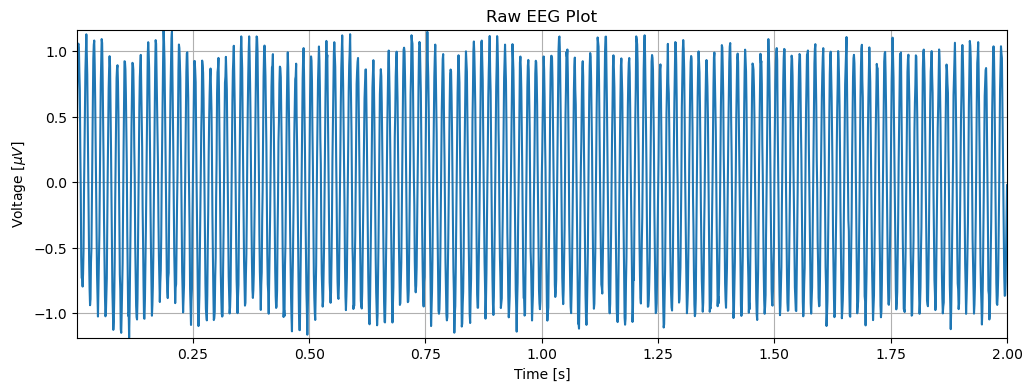

In [104]:
data = loadmat("data/03_EEG-1.mat")
EEG = data["EEG"][:, 0]
t = data["t"][0]

plt.plot(t, EEG)
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("Voltage [$\mu V$]")
plt.title("Raw EEG Plot")
plt.autoscale(tight=True)
plt.savefig("figs/power_spectrum/raw_data")
plt.show()

By visually inspecting this plot, we can see that there seems to be a recurring rhythmic pattern. To calculate the frequency of this pattern, we must count the number of oscillations per second. Counting the peaks over the full two second time series would be quite arduous, so plotting a shorter time segment and extrapolating from that data will be more useful.

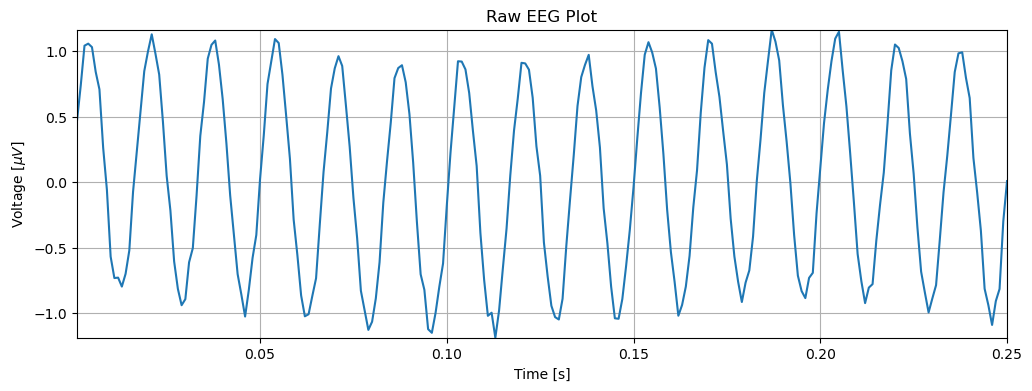

In [146]:
time_step = t[-1] / len(t) # Calculates sampling interval = 0.001.
plt.plot(t[:250], EEG[:250])
plt.grid()
plt.xlabel("Time [s]")
plt.ylabel("Voltage [$\mu V$]")
plt.title("Raw EEG Plot")
plt.autoscale(tight=True)
plt.show()

In 0.25 seconds, 15 oscillations occur meaning the recurring rhythm has a frequency of 60 Hz. EEG rhythyms with frequencies between 40-80 Hz are referred to as **gamma bands** and are thought to be very important for coginitve processing in the brain. 

However, this rhythmic pattern does not seem to be representative of a true EEG recording. Neural activity does not typically follow a constant pattern over multiple seconds (as shown in this data), and therefore neither should the EEG measuring that activity. This leads us to believe that there is noise interfering with the EEG recording.

Coincidentally, the alternating current of the average North American electrical socket alternates at 60 Hz. and this provides a viable explanation for the constant rhythym appearing in this data. Unfortunately, the data must be processed and viewed differently to highlight the salient portions of the signal measured by the EEG.

### Useful Datapoints

In [106]:
time_step = t[-1] / len(t) # Calculates sampling interval = 0.001.
samples = len(EEG) # Calculates total number of data points = 2000.
time = samples * time_step # Total time of the EEG = 2.0s.
mean = EEG.mean()
variance = EEG.var()
std = EEG.std()

### Autocovariance

Autocovariance is a feature of a dataset that can be very useful for characterizing emerging patterns. Unlike variance, which measures the average square difference between the datapoints and their mean, autocovariance provides a measure of perioidicity within a dataset. 

#### Variance:
$$
  \sigma^2 = \frac{1}{N}\sum_{n=1}^{N}(x_n - \bar x)^2.
$$

#### Autocovariance:
$$
  r_{xx}[L] = \frac{1}{N}\sum_{n=1}^{N-L}(x_{n+L} - \bar x)(x_n - \bar x).
$$

Autocovariance compares values at a lag, L, further position in the dataset to current values in an effort to find rhythmic activity. A higher autocovariance corresponds to a greater periodicity.

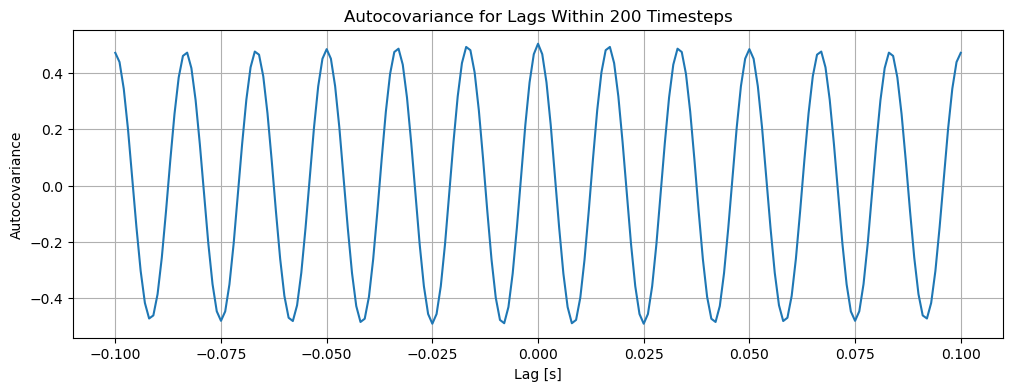

In [107]:
lags = np.arange(-len(EEG) + 1, len(EEG))
ac_variance = 1 / samples * np.correlate((EEG - mean), (EEG - mean), mode="full") # Calculating autocovariance vector
inds = np.abs(lags) <= 100
plt.plot(lags[inds] * time_step, ac_variance[inds])
plt.grid()
plt.xlabel("Lag [s]")
plt.ylabel("Autocovariance")
plt.title("Autocovariance for Lags Within 200 Timesteps")
plt.savefig("figs/power_spectrum/autocovariance_1")
plt.show()

In this 0.200 second time series of autocovariance, we can see that there are 12 oscillations at a frequency is 60Hz which is equal to the frequency of the raw data. Lets see how the autocovariance differs for different lag values.

For L1, Autocovariance = -0.4901
For L2, Autocovariance = 0.487
For random lag, Autocovariance = -0.0007176


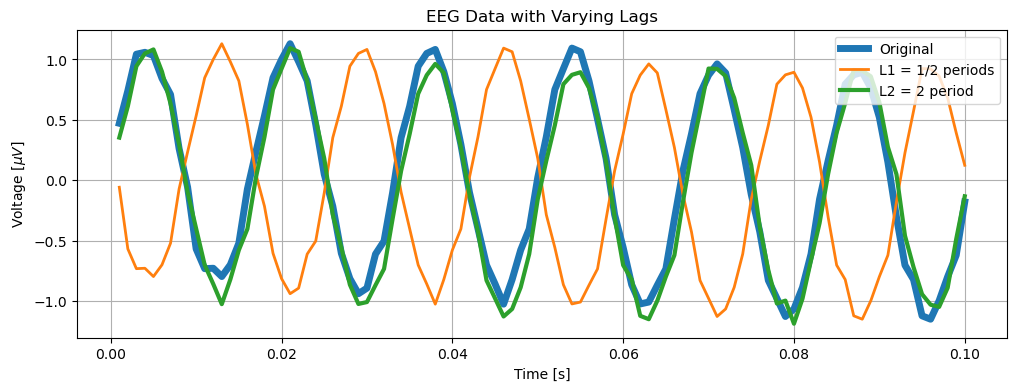

In [140]:
import random

idxs = np.arange(100)
plt.plot(t[idxs], EEG[idxs], label="Original", lw=5) # Plot of original EEG data.                         
L1 = int(1/2 * 1/60 / time_step) # Lag of half a period.
L2 = int(2 * 1/60 / time_step) # Lag of two periods.
plt.plot(t[idxs], EEG[idxs + L1], label="L1 = 1/2 periods", lw=2)
print("For L1, Autocovariance = {:.4}".format(ac_variance[lags==L1][0]))
plt.plot(t[idxs], EEG[idxs + L2], label="L2 = 2 period", lw=3)
print("For L2, Autocovariance = {:.4}".format(ac_variance[lags==L2][0]))
print("For random lag, Autocovariance = {:.4}".format(ac_variance[lags==random.randrange(0, len(EEG))][0]))
plt.grid()
plt.legend(loc="upper right")
plt.xlabel("Time [s]")
plt.ylabel("Voltage $[\mu V]$")
plt.title("EEG Data with Varying Lags")
plt.savefig("figs/power_spectrum/eeg_diff_lags")
plt.show()

The original curve (blue) and the curve with a lag of 2 periods (green) appear to overlay, whereas the curve with a 1/2 period lag (orange) appears to have an inverse relationship with the original, indicating similar frequency. Additionally, the autocovariances for both lag values appear to be far greater than the random lag value. This all lends to a high similarity in the periodicity of the plotted lags.

Lets plot the autocovariance again to see where these lags appear on the graph.

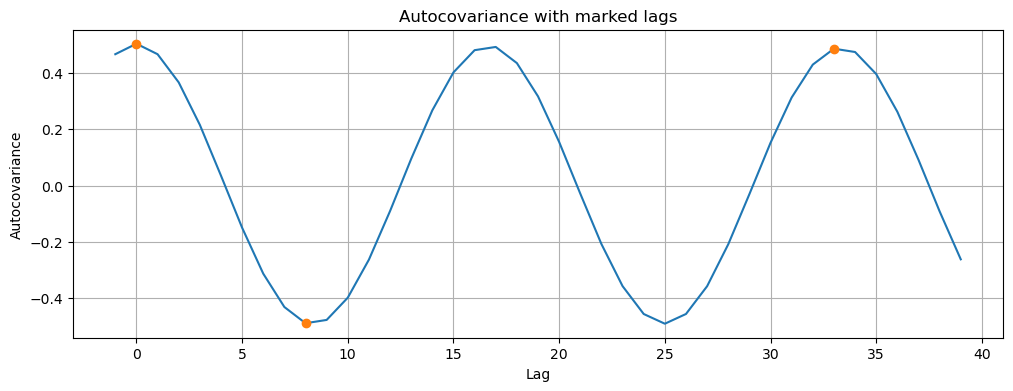

In [141]:
idxs = [l in range(-1, 40) for l in lags]        
plt.plot(lags[idxs], ac_variance[idxs])                       
L = [0, 33, 8]                                   # Consider our three specific lags
plt.plot(sorted(L), ac_variance[[l in L for l in lags]], 'o') 
plt.grid()
plt.xlabel('Lag')                                    
plt.ylabel('Autocovariance');
plt.title("Autocovariance with marked lags")
plt.savefig("figs/power_spectrum/acvar_with_lags")
plt.show()

#### What does this tell us?
Using visual inspection, the strong rhythymic component of the EEG data is apparent with a dominant 60 Hz frequency. This rhythmic structure is further confirmed by the appearance of that 60 Hz frequency at the lags that coincide with the peaks and troughs of the above plot. 

### Power Spectral Density:

Another method for characterizing the rhythmic activity of EEG data is the power spectral density, or spectrum. The spectrum returns power of the rhythmic activity being analyzed as a function of frequency. 

#### Spectrum Equation: $$ S_{xxj} = \frac{2\Delta ^ 2}{T}X_jX_j^* $$ 
$\Delta$ = Sampling interval

$T$ = Total time of sampling

$X_j$ = Fourier Transform of dataset

$X_j^*$ = Complex Conjugate of Fourier Transform


#### Fourier Transform Equation: $$ X_j = \sum_{n=1}^N x_n\exp(-2\pi if_jt_n) $$
$N$ = Number of samples

$x_n$ = Data point at timestep n

$f_j$ = Frequency $\frac{j}{T}$, where $j = \{-N/2 + 1, -N/2 + 2,..., N/2 - 1, N/2\}$

$t_n$ = Timestep n

The Fourier Transform is useful because it represents the data as a linear combination of sinusoids with different frequencies. Although it may be difficult to visualize this definition for the Fourier Transform from the above equation, it can be rewritten using Euler's Identity as follows:
$$X_j = \sum_{n=1}^Nx_n\cos(-2\pi f_jt_n) + i\sum_{n=1}^Nx_n\sin(-2\pi f_jt_n)$$
In practice, the Fourier Transform can isolate the signals that appear within the EEG recording. It transforms the signal from the time domain to the frequency domain, allowing us to visualize which frequencies are apparent in the recording along with their relative strengths. In our visualization, we will clip the visualized frequency values to an important value called the **Nyquist frequency**. The Nyquist frequency is the maximum signal frequency we can observe for a given sampling rate without aliasing. Aliasing occurs when the sampling rate is not high enough to accurately reconstruct the provided signal, therefore an aliased signal will show a lower frequency than the true signal.

The Nyquist frequency is calculate as half the dataset's sampling frequency, $f_{nq} = f_0 / 2$ where $f_0$ is the sampling frequency. The sampling frequency of our dataset is 1000Hz, so the Nyquist frequency is 500Hz. 

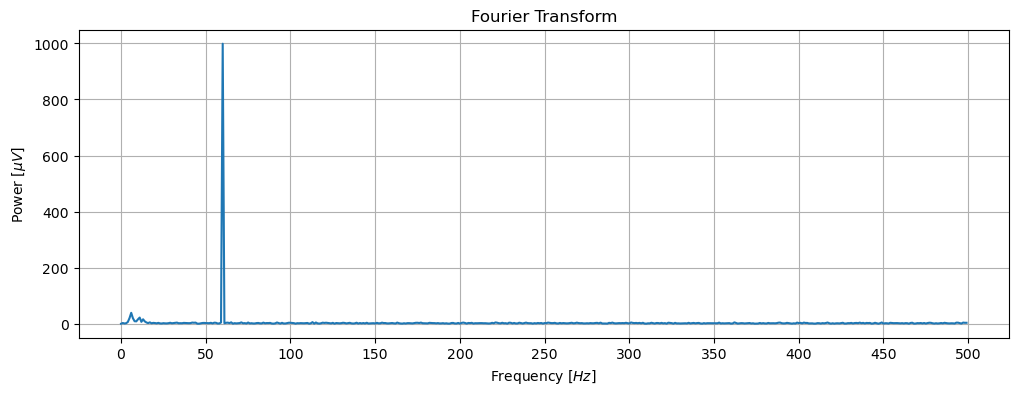

In [145]:
nyquist = 1 / time_step / 2
fj = np.arange(0, nyquist, step=1)
fj = fj.reshape((-1, 1))
fj_sin = np.sin(-2 * np.pi * fj @ t.reshape((1, -1)))
fj_cos = np.cos(-2 * np.pi * fj @ t.reshape((1, -1)))
cos_product = fj_cos * EEG.reshape((1, -1)) # Calculation of cosine term of Fourier Transform equation.
sin_product = fj_sin * EEG.reshape((1, -1))  # Calculation of sine term of Fourier Transform equation.
mag = np.sqrt(cos_product.sum(axis=1) ** 2 + sin_product.sum(axis=1) ** 2) # Magnitude of Fourier Transform.
plt.grid()
plt.xlabel("Frequency $[Hz]$")
plt.ylabel("Power $[\mu V]$")
plt.xticks(np.arange(0, 501, 50))
plt.title("Fourier Transform")
plt.plot(fj, mag)
plt.show()

Note that when a signal is real, the Fourier Transform observed at a certain frequency, $f$,  is equal to the Fourier Tranform observed at $-f$. Thus, we can ignore the redundant negative frequencies (-500, -1). Above, we were able to isolate a single strong amplitude that appears to be at the 60Hz frequency we observed in our earlier analysis. 

#### Power Spectral Density:

The magnitude of the Fourier Transform is dependent on the total time of sampling. If we revisit the equation for the DFT mentioned above, we can see that the Fourier Transform is the sum of all datapoints over the entire length of the signal. There are many scenarios where this dependence on signal length can be detrimental, ie. comparing signals of different lengths, comparing windows of different length within the same signal, etc. To handle this dependence on signal length, we time-normalize the Fourier Transform to compute the **Power Spectral Density**, also called the **spectrum**.

#### Spectrum equation
$$S_{xx, j} = \frac{2\Delta ^ 2}{T}X_jX_j^*$$
$\Delta$ = Sampling interval

$T$ = Total sampling time.

$X_j$ = Fourier Transform

$X_j^*$ = Complex Conjugate of Fourier Transform


Lets plot the spectrum.

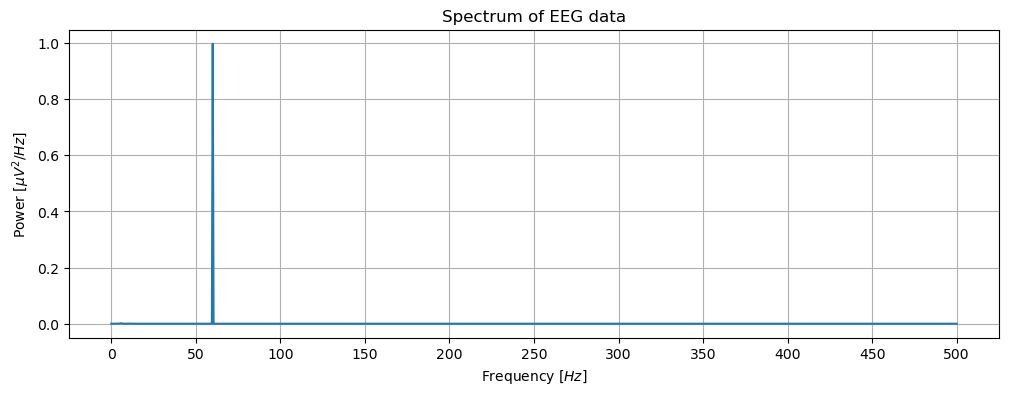

In [143]:
fourier_EEG = rfft(EEG - mean)# Calculating Fourier Transform. Subtracting from mean eliminates slow data (0 Hz) activity because it does not represent any rhythmic activity.
Sxx = (2 * time_step ** 2 / time * fourier_EEG * fourier_EEG.conj()).real # Calculate Spectrum
freq_res = 1 / time 
faxis = np.arange(len(Sxx)) * freq_res # Frequency resolution adjusts sampling rate of spectrum to be bound by Nyquist Frequency.
plt.plot(faxis, Sxx)
plt.grid()
plt.xlabel("Frequency $[Hz]$")
plt.ylabel("Power [$\mu V^2/Hz$]")
plt.xticks(np.arange(0, 501, 50))
plt.title("Spectrum of EEG data")
plt.savefig("figs/power_spectrum/eeg_spectrum_unscaled")
plt.show()

We now have a spectrum with time-normalized units that represent the frequency of the most dominant rhythm in the data. What does this plot tell us? Lets recall the explanation we provided for the 60Hz signal earlier in this study: an electrical socket. Because the power of this noise has such a high amplitude, the true frequencies of the EEG are drowned out. To recover this "drowned out" data, we must use **decibel scaling**. 

Changing the units of power from $\frac{\mu V^2}{Hz}$ to $dB$ should allow for other amplitudes to be observable due to the logarithmic nature of the decibel scale.  

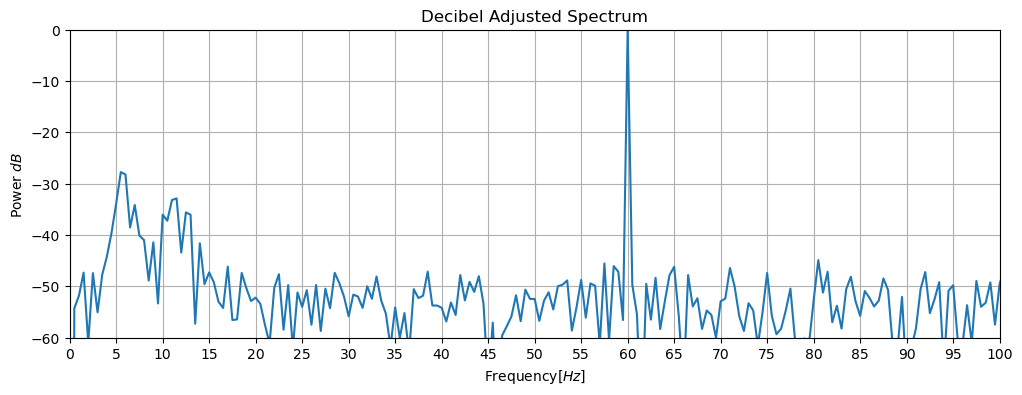

In [144]:
plt.plot(faxis, 10 * np.log10(Sxx/Sxx.max())) # Plots spectrum in decibels. Divides by max Sxx value to use 60Hz value as a reference.
plt.grid()
plt.xlim([0, 100])
plt.ylim([-60, 0])
plt.xlabel("Frequency$[Hz]$")
plt.ylabel("Power $dB$")
plt.xticks(np.arange(0, 101, 5))
plt.title("Decibel Adjusted Spectrum")
plt.savefig("figs/power_spectrum/decibel_adjusted_spectrum")
plt.show()

Two new peaks emerge in the adjusted decibel spectrum at 6 Hz and 11 Hz. These both seem to to have a power of about -30 dB or 3 orders of magnitude less than the power of the 60 Hz frequency. The power of these signals is far weaker than that of the electrical socket which is why we were unable to see the  before the logarithmic scaling.

The emergence of these two new peaks opens our analysis to more questions. We knew the 60 Hz signal was present throughout the recording because it came from the electrical socket, however, are the other rhythms present throughout the recording? Do they ebb and flow? Do they have a specific onset visible in the recording? We will answer these questions with a **spectrogram**. 

A spectrogram breaks a time series into windows and calculates the spectrum over each of those smaller windows. It allows for three axes to be measured and visualized: frequency, time, and power. 

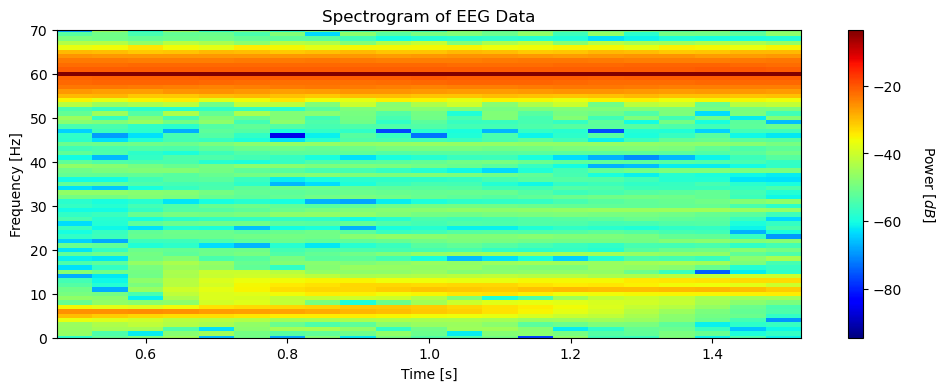

In [151]:
Fs = 1 / time_step         # Calculates sampling frequency
interval = int(Fs) 
overlap = int(Fs * 0.95)

f, t, Sxx = spectrogram(
    EEG,                   # Dataset.
    fs=Fs,                 # Sampling frequency
    nperseg=interval,      # Length of a segment = sampling frequency
    noverlap=overlap)      # Number of samples to overlap
plt.pcolormesh(t, f, 10 * np.log10(Sxx), cmap='jet')
cbar = plt.colorbar()             # Represents power
plt.ylim([0, 70])
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
cbar.set_label('Power [$dB$]', rotation=270, labelpad=25)
plt.title("Spectrogram of EEG Data")
plt.savefig("figs/power_spectrum/spectrogram")
plt.show()

The three frequencies we previously obsevered are still present, however the spectrogram allows us to identify the times for which each frequency is observed. As we suspected, the 60 Hz band is the strongest and is present throughout the signal. Both the 6 Hz and 11 Hz bands appear to be far weaker and are only present for a finite period of time.